In [1]:
import numpy as np
import pandas as pd
import os
#from osgeo import gdal
import geopandas as gpd
#import rasterio
import osmnx as ox
import rioxarray
import pyproj
import shapely.geometry as sg
import networkx as nx

In [14]:
# Test data
test_path = "C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/TestData/"
single_point = gpd.read_file(test_path + "Test_single_home_location.gpkg")
multi_point = gpd.read_file(test_path + "Test_multiple_home_locations.gpkg")
polygon = gpd.read_file(test_path + "TestArea.gpkg")
ndvi = rioxarray.open_rasterio(test_path + "NDVI_data_test.tif")
land_cover = rioxarray.open_rasterio(test_path + "Landcover_data_test.tif")
network = gpd.read_file(test_path + "test_network.gpkg", layer='edges')

single_point_geographic = single_point.to_crs('epsg:4326')

In [15]:
# Function to create isochrone polygon of network
def make_iso_poly(G, edge_buff=25, node_buff=0, center_node=None, trip_time=None):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time") # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters

    node_points = [sg.Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)] # Create list of point geometries existing of x and y coordinates for each node in subgraph retrieved from previous step
    nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points) # Create geodataframe containing data from previous step
    nodes_gdf = nodes_gdf.set_index("id") # Set index to node ID

    edge_lines = []
    for n_fr, n_to in subgraph.edges(): # Iterate over edges in subgraph
        f = nodes_gdf.loc[n_fr].geometry # Retrieve geometry of the 'from' node of the edge
        t = nodes_gdf.loc[n_to].geometry # Retrieve geometry of the 'to' node of the edge
        edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", sg.LineString([f, t])) # Retrieve edge geometry between from and to nodes
        edge_lines.append(edge_lookup) # Append edge geometry to list of edge lines

    n = nodes_gdf.buffer(node_buff).geometry # Create buffer around the nodes
    e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry # Create buffer around the edges
    all_gs = list(n) + list(e) # Concatenate nodes and edges
    isochrone_poly = gpd.GeoSeries(all_gs).unary_union # Create polygon of the concatenated nodes and edges

    isochrone_poly = sg.Polygon(isochrone_poly.exterior) # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
    
    return isochrone_poly

# Greenness Availability -- Mean NDVI

In [47]:
def get_mean_NDVI(point_of_interest_file, ndvi_raster_file, buffer_dist=None, buffer_type=None, network_file=None, network_type=None,
                  trip_time=None, travel_speed=None, output_dir=os.getcwd()):
    # Read and process user input, check conditions
    poi = gpd.read_file(point_of_interest_file)
    if not poi.crs.is_projected:
        raise ValueError("The CRS of the PoI dataset is currently geographic, please transform it into a local projected CRS and re-run the function")
    
    if poi['id'].isnull().values.any():
        poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)

    # Save EPSG code of study area
    epsg = poi.crs.to_epsg()

    ndvi_src = rioxarray.open_rasterio(ndvi_raster_file)
    if not ndvi_src.rio.crs.to_epsg() == epsg:
                    print("Adjusting CRS of NDVI file to match with Point of Interest CRS...")
                    ndvi_src.rio.write_crs(f'EPSG:{epsg}', inplace=True)
                    print("Done")

    # Make sure all points of interest are within the NDVI raster provided
    if not all(geom.within(sg.box(*ndvi_src.rio.bounds())) for geom in poi['geometry']):
        raise ValueError("Not all points of interest are within the NDVI file provided, please make sure they are and re-run the function")

    # Create buffers (or not) based on user input        
    if poi.iloc[0]['geometry'].geom_type == "Point":
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")
    
        if buffer_type == "euclidian":
            if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                raise TypeError("Please make sure that the buffer distance is set as a positive integer")             

            aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'].buffer(buffer_dist))
        else:
            if network_file is not None and (not os.path.splitext(network_file)[1] == ".gpkg"):
                raise ValueError("Please provide the network file in '.gpkg' format")
            elif network_file is not None and (os.path.splitext(network_file)[1] == ".gpkg"):
                network = gpd.read_file(network_file, layer='edges')
            else:
                network = None

            if network is None:
                if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                    raise TypeError("Please make sure that the buffer distance is set as a positive integer")

                if network_type not in ["walk", "bike", "drive", "all"]:
                    raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")
                
                if not isinstance(travel_speed, int) or (not travel_speed > 0):
                    raise TypeError("Please make sure that the travel speed is set as a positive integer")

                if not isinstance(trip_time, int) or (not trip_time > 0):
                    raise TypeError("Please make sure that the trip time is set as a positive integer")             
        
                meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
                epsg_transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326")

                # Transform the geometry column to lat-lon coordinates
                aoi_geometry = []
                for geom in poi['geometry']:
                    latlon = epsg_transformer.transform(geom.x, geom.y) # Transform point geometry into latlon for OSMnx
                    graph = ox.graph_from_point(latlon, network_type=network_type, dist=buffer_dist) # Retrieve street network for desired network type and buffer distance surrounding poi
                    nodes = ox.graph_to_gdfs(graph, edges=False) # Create geodataframe which contains only the nodes of the street network
                    x, y = nodes["geometry"].unary_union.centroid.xy # Calculate centroid of node geometries 
                    center_node = ox.distance.nearest_nodes(graph, x[0], y[0]) # Find node which is closest to centroid as base for next steps
                    graph = ox.project_graph(graph) # Project street network graph back to original poi CRS
                    graph_epsg = graph.graph['crs'].to_epsg() # Store EPSG code used for previous step
                    for _, _, _, data in graph.edges(data=True, keys=True): # Calculate the time it takes to cover each edge's distance
                        data["time"] = data["length"] / meters_per_minute
                    isochrone_poly = make_iso_poly(graph, center_node=center_node, trip_time=trip_time) # See separate function for line by line explanation
                    aoi_geometry.append(isochrone_poly)

                aoi_gdf = gpd.GeoDataFrame(geometry=aoi_geometry, crs=f"EPSG:{graph_epsg}").to_crs(f"EPSG:{epsg}")    
            else:
                if not network.crs.to_epsg() == epsg:
                    print("Adjusting CRS of Network file to match with Point of Interest CRS...")
                    network.to_crs(f'EPSG:{epsg}', inplace=True)
                    print("Done")

                # Create bounding box for network file
                bbox_network = network.unary_union.convex_hull

                if not all(geom.within(bbox_network) for geom in poi['geometry']):
                     raise ValueError("Not all points of interest are within the network file provided, please make sure they are and re-run the function")

                aoi_gdf = gpd.GeoDataFrame(geometry=[bbox_network], crs=f'EPSG:{epsg}')
    else:
        aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'])

    # Calculate mean NDVI values
    poi['mean_NDVI'] = aoi_gdf.apply(lambda row: ndvi_src.rio.clip([row.geometry]).clip(min=0).mean().values.round(3), axis=1)

    print("Writing results to new geopackage file in specified directory...")
    input_filename, ext = os.path.splitext(point_of_interest_file)
    poi.to_file(os.path.join(output_dir, f"{input_filename}_ndvi_added.gpkg"), driver="GPKG")
    print("Done")
    
    return poi

In [48]:
mean_ndvi = get_mean_NDVI(point_of_interest_file=test_path + "Test_multiple_home_locations.gpkg", ndvi_raster_file=test_path + "NDVI_data_test.tif", 
buffer_dist=1500, buffer_type="network", travel_speed=15, trip_time=5, network_type='bike', output_dir=test_path)

Writing results to new geopackage file in specified directory...
Done


In [49]:
mean_ndvi

,id,geometry,mean_NDVI
0,1,POINT (388644.249 392861.634),0.169
1,2,POINT (385981.911 393805.494),0.164
2,3,POINT (388631.230 395322.181),0.200


# Greenness Availability -- Land Cover Percentages

In [37]:
# define function to calculate land cover percentages for a single geometry
def calculate_landcover_percentages(landcover_src, geometry):
    clipped = landcover_src.rio.clip([geometry]).clip(min=0)
    unique, counts = np.unique(clipped.values, return_counts=True)
    total = counts.sum()
    percentages = {value: str((count / total * 100).round(3)) + "%" for value, count in zip(unique, counts)}
    return percentages

In [52]:
def get_landcover_percentages(point_of_interest_file, landcover_raster_file, buffer_dist=None, buffer_type=None, network_file=None, 
                              network_type=None, trip_time=None, travel_speed=None, output_dir=os.getcwd()):
    # Read and process user input, check conditions
    poi = gpd.read_file(point_of_interest_file)
    if not poi.crs.is_projected:
        raise ValueError("The CRS of the PoI dataset is currently geographic, please transform it into a local projected CRS and re-run the function")
    
    if poi['id'].isnull().values.any():
        poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)

    # Save EPSG code of study area
    epsg = poi.crs.to_epsg()

    landcover_src = rioxarray.open_rasterio(landcover_raster_file)
    if not landcover_src.rio.crs.to_epsg() == epsg:
                    print("Adjusting CRS of Land Cover file to match with Point of Interest CRS...")
                    landcover_src.rio.write_crs(f'EPSG:{epsg}', inplace=True)
                    print("Done")

    # Make sure all points of interest are within the NDVI raster provided
    if not all(geom.within(sg.box(*landcover_src.rio.bounds())) for geom in poi['geometry']):
        raise ValueError("Not all points of interest are within the Land Cover file provided, please make sure they are and re-run the function")

    # Create buffers (or not) based on user input        
    if poi.iloc[0]['geometry'].geom_type == "Point":
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")
    
        if buffer_type == "euclidian":
            if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                raise TypeError("Please make sure that the buffer distance is set as a positive integer")             

            aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'].buffer(buffer_dist))
        else:
            if network_file is not None and (not os.path.splitext(network_file)[1] == ".gpkg"):
                raise ValueError("Please provide the network file in '.gpkg' format")
            elif network_file is not None and (os.path.splitext(network_file)[1] == ".gpkg"):
                network = gpd.read_file(network_file, layer='edges')
            else:
                network = None

            if network is None:
                if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                    raise TypeError("Please make sure that the buffer distance is set as a positive integer")

                if network_type not in ["walk", "bike", "drive", "all"]:
                    raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")
                
                if not isinstance(travel_speed, int) or (not travel_speed > 0):
                    raise TypeError("Please make sure that the travel speed is set as a positive integer")

                if not isinstance(trip_time, int) or (not trip_time > 0):
                    raise TypeError("Please make sure that the trip time is set as a positive integer")             
        
                meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
                epsg_transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326")

                # Transform the geometry column to lat-lon coordinates
                aoi_geometry = []
                for geom in poi['geometry']:
                    latlon = epsg_transformer.transform(geom.x, geom.y) # Transform point geometry into latlon for OSMnx
                    graph = ox.graph_from_point(latlon, network_type=network_type, dist=buffer_dist) # Retrieve street network for desired network type and buffer distance surrounding poi
                    nodes = ox.graph_to_gdfs(graph, edges=False) # Create geodataframe which contains only the nodes of the street network
                    x, y = nodes["geometry"].unary_union.centroid.xy # Calculate centroid of node geometries 
                    center_node = ox.distance.nearest_nodes(graph, x[0], y[0]) # Find node which is closest to centroid as base for next steps
                    graph = ox.project_graph(graph) # Project street network graph back to original poi CRS
                    graph_epsg = graph.graph['crs'].to_epsg() # Store EPSG code used for previous step
                    for _, _, _, data in graph.edges(data=True, keys=True): # Calculate the time it takes to cover each edge's distance
                        data["time"] = data["length"] / meters_per_minute
                    isochrone_poly = make_iso_poly(graph, center_node=center_node, trip_time=trip_time) # See separate function for line by line explanation
                    aoi_geometry.append(isochrone_poly)

                aoi_gdf = gpd.GeoDataFrame(geometry=aoi_geometry, crs=f"EPSG:{graph_epsg}").to_crs(f"EPSG:{epsg}")    
            else:
                if not network.crs.to_epsg() == epsg:
                    print("Adjusting CRS of Network file to match with Point of Interest CRS...")
                    network.to_crs(f'EPSG:{epsg}', inplace=True)
                    print("Done")

                # Create bounding box for network file
                bbox_network = network.unary_union.convex_hull

                if not all(geom.within(bbox_network) for geom in poi['geometry']):
                     raise ValueError("Not all points of interest are within the network file provided, please make sure they are and re-run the function")

                aoi_gdf = gpd.GeoDataFrame(geometry=[bbox_network], crs=f'EPSG:{epsg}')
    else:
        aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'])

    # apply the function to each geometry in the GeoDataFrame and create a new Pandas Series
    landcover_percentages_series = aoi_gdf.geometry.apply(lambda x: pd.Series(calculate_landcover_percentages(landcover_src=landcover_src, geometry=x)))
    # rename the columns with the land cover class values
    landcover_percentages_series.columns = ["class_" + str(col) for col in landcover_percentages_series.columns]
    # concatenate the new series to the original dataframe
    poi = pd.concat([poi, landcover_percentages_series], axis=1)

    print("Writing results to new geopackage file in specified directory...")
    input_filename, ext = os.path.splitext(point_of_interest_file)
    poi.to_file(os.path.join(output_dir, f"{input_filename}_LCperc_added.gpkg"), driver="GPKG")
    print("Done")

    return poi

In [53]:
lc_perc = get_landcover_percentages(point_of_interest_file=test_path + "Test_multiple_home_locations_ndvi_added.gpkg",
landcover_raster_file=test_path + "Landcover_data_test.tif", buffer_dist=1500, buffer_type="network", travel_speed=15, trip_time=5, 
network_type='bike')

Writing results to new geopackage file in specified directory...
Done


In [54]:
lc_perc

,id,mean_NDVI,geometry,class_0,class_1001,class_1002,class_1003,class_1004,class_1005,class_1101,...,class_1501,class_1505,class_2001,class_2003,class_2004,class_2005,class_1502,class_1503,class_1504,class_2002
0,1,0.169,POINT (388644.249 392861.634),47.251%,16.47%,0.005%,1.594%,0.839%,2.758%,0.25%,...,0.122%,0.005%,0.047%,0.026%,0.016%,0.034%,NaN,NaN,NaN,NaN
1,2,0.164,POINT (385981.911 393805.494),54.316%,12.181%,0.004%,1.6%,0.693%,3.76%,1.408%,...,0.03%,0.022%,0.162%,0.058%,0.062%,0.208%,0.002%,0.016%,0.008%,NaN
2,3,0.200,POINT (388631.230 395322.181),48.487%,12.037%,0.006%,0.819%,1.218%,1.774%,0.544%,...,0.089%,0.003%,0.207%,0.08%,0.174%,0.216%,NaN,NaN,NaN,0.009%


# Plots

### NDVI

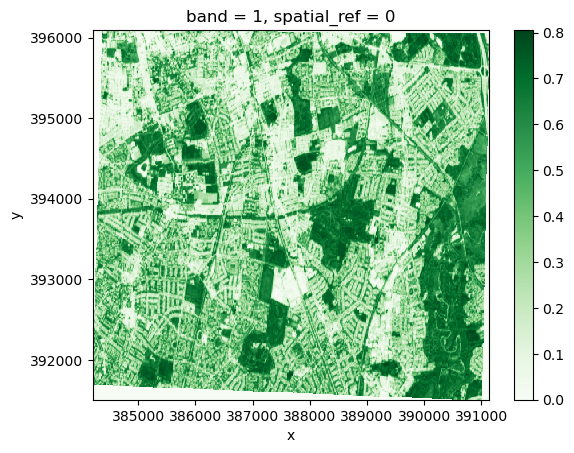

In [11]:
ndvi.clip(min=0).plot(cmap="Greens")

### Land Cover

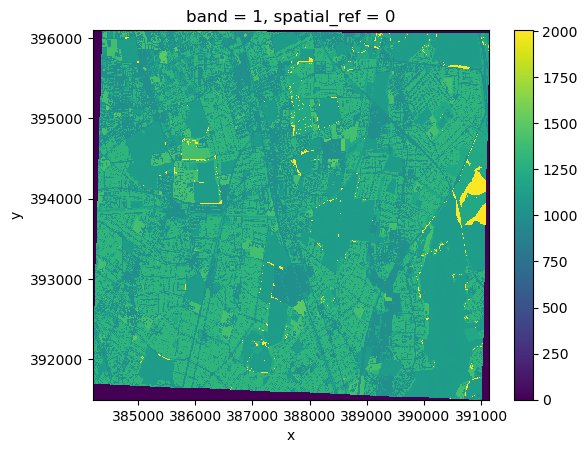

In [14]:
land_cover.clip(min=0).plot()